In [1]:
import pickle
import my_tools
import matplotlib.pyplot as plt

%matplotlib inline

# References
Ref /1

[Udacity Project Description](https://classroom.udacity.com/nanodegrees/nd002-airbus/parts/96af8ace-b538-440f-83e6-4cc6eb42caa5/modules/317428862475461/lessons/3174288624239847/concepts/31726388830923)

Ref /2

[Enron Email Corpus](https://www.cs.cmu.edu/~enron/)

Ref /3

[Sklearn Documentation](http://scikit-learn.org/stable/index.html)

# Project Overview
The goal of this project is to use machine learning techniques in order to identify persons of interest, who might have been involved in one of America's biggest fraud cases which is summarized below:

"In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. In this project, you will play detective, and put your new skills to use by building a person of interest identifier based on financial and email data made public as a result of the Enron scandal. To assist you in your detective work, we've combined this data with a hand-generated list of persons of interest in the fraud case, which means individuals who were indicted, reached a settlement or plea deal with the government, or testified in exchange for prosecution immunity." (see Ref /1)

This use case is particularly interesting to data analysts, because a big data set, containing email messages from Enron employees and related individuals has been made public during the court case which followed, when the fraud came to light. (see Ref /2)

Part of this data set, enriched with financial information about some of the persons in the data set, was provided by Udacity for this project. The data is available in *final_project_dataset.pkl*.

The steps taken in order to achieve the project goal are described in the following chapters. The approach is suggested during the Machine Learning module of the Udacity course and includes the following aspects:
* Dataset/Questions
* Features
* Algorithms
* Evaluations

# Dataset
The data set provided as *final_project_dataset.pkl* contains a Python dictionary. The dictionary has entries for a number of persons, for which the Enron email corpus and/or the financial data set contains entries.

## Statistics

In [2]:
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

entry_no = len(data_dict.keys())
    
print 'Number of entries in data set: ', entry_no

Number of entries in data set:  146


The feature *email_address* is represented as string, all other features are numeric values. Statistics on the numerical features are shown below.

In [3]:
feature_stats = my_tools.feature_stats(data_dict)
feature_stats

,available_no,available_pct,max,min,mean,median
salary,95,65.07,26704229,477,562194,259996
to_messages,86,58.9,15149,57,2073.86,1211
deferral_payments,39,26.71,32083396,-102500,1.64267e+06,227449
total_payments,125,85.62,309886585,148,5.08153e+06,1.10139e+06
exercised_stock_options,102,69.86,311764000,3285,5.98705e+06,1.31081e+06
bonus,82,56.16,97343619,70000,2.37423e+06,769375
restricted_stock,110,75.34,130322299,-2604490,2.32174e+06,451740
shared_receipt_with_poi,86,58.9,5521,2,1176.47,740.5
restricted_stock_deferred,18,12.33,15456290,-7576788,166411,-146975
total_stock_value,126,86.3,434509511,-44093,6.77396e+06,1.10287e+06


## Outliers
A couple of the maxima seem too far off to be correct, especially when taking into account the big difference between median and mean values. A mean value much higher than the median is a sign of outliers. These could either be real values or errors in the data.

As shown in the course material, there is an entry in the financial data for the total of all values, which needs to be removed. For the remainder of the values sigificant variation can be found. However, an outlier is defined as a deviation from an expected value. We do not know, what the expected values for most of the features might be. Therefore, I will not remove any further entries, as these might be relevant for the detection of persons of interest.

In [4]:
del data_dict['TOTAL']

We can see from the statistics above, that the availability of the data is very different, depending on the feature.

Total stock value is available for approximately 86 percent of the persons in the data set, whereas, the loan advances are available only for three percent.

This will be of great importance later on during feature selection.

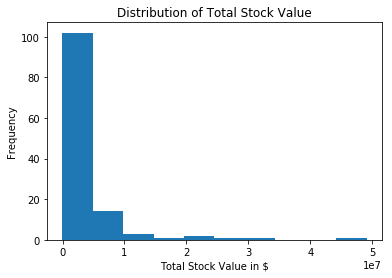

In [5]:
total_stock = [data_dict[person]['total_stock_value'] for person in data_dict.keys() if str(data_dict[person]['total_stock_value']) != 'NaN']

plt.hist(total_stock)
plt.title('Distribution of Total Stock Value')
plt.xlabel('Total Stock Value in $')
plt.ylabel('Frequency')
plt.show()

As can be seen from the plot above, the total stock value is heavily skewed to the left. However, as we are looking for persons of interest, who can be seen as a kind of outlier with regards to their finances, this is quite possible. 

# Features
## New Feature
Two new features containing the ratio between long term incentive and salary and long term incentive and bonus respectively will be created in order to determine if especially low long term incentives, when compared with salary or bonus is an indicator for involvement in the fraud:

**long_term_incentive_vs_salary** = 100 - (long term incentive / salary)

**long_term_incentive_vs_bonus** = 100 - (long term incentive / bonus)

In [6]:
data_dict = my_tools.new_feature(data_dict)

## Feature Reduction
Several methods will be used for feature reduction.

In a first step some of the obvious features are deselected. These are *poi*, because it is the label and *email_address*, because it is not numeric and corresponds to the persons names. This feature would be used, if we were to investigate the actual texts of the the emails, which we do not intend to do during this exercise.

In [7]:
feature_stats = my_tools.feature_stats(data_dict)
features_list = ['poi'] + list(feature_stats.index)

In a second step, features are deselected, because of low data availability. In order to do this, we need to know the number of POIs in the data set:

In [8]:
poi_no = len([data_dict[person] for person in data_dict.keys() if data_dict[person]['poi'] == 1])
print 'Number of POIs in data set: ', poi_no

Number of POIs in data set:  18


Let's assume a train/test split of three to one for the purpose of this investigation. If we consider two as the minimum number of POIs in the test data set, we will need an average number of eight POIs or

In [9]:
print round(8/18.0,2) * 100, '%'

44.0 %


available for the investigation. Therefore, the minimum number of entries for each individual feature would be

In [10]:
print int(8/18.0 * entry_no)

64


The following features are therefore deselected:

In [11]:
feature_availability_low = feature_stats[feature_stats['available_no'] < 64]
feature_availability_low

,available_no,available_pct,max,min,mean,median
deferral_payments,38,26.21,6426990,-102500,841603,221064
deferred_income,48,33.1,-833,-3504386,-581050,-151927
restricted_stock_deferred,17,11.72,15456290,-1787380,621893,-140264
loan_advances,3,2.07,81525000,400000,2.7975e+07,2e+06
long_term_incentive_vs_bonus,57,39.31,99.9593,88.8261,99.0796,99.3846
director_fees,16,11.03,137864,3285,89822.9,106164


In [12]:
for feature in feature_availability_low.index:
    features_list.remove(feature)
    
features_list

['poi',
 'to_messages',
 'expenses',
 'long_term_incentive',
 'shared_receipt_with_poi',
 'from_messages',
 'other',
 'bonus',
 'total_stock_value',
 'from_poi_to_this_person',
 'long_term_incentive_vs_salary',
 'from_this_person_to_poi',
 'restricted_stock',
 'salary',
 'total_payments',
 'exercised_stock_options']

In [13]:
# poi is disregarded, as this is the label
print 'Number of features to be investigated: ', len(features_list[1:])

Number of features to be investigated:  15


## SelectKBest
In this chapter, a ranking of the remaining features is built, based on SelectKBest. The features with the highest scores will be added first, when assessing the performance of the algorithms in the next chapter.

In [14]:
best_features = my_tools.best_features(data_dict, features_list)
best_features

,scores
exercised_stock_options,25.097542
total_stock_value,24.467654
bonus,21.060002
salary,18.575703
long_term_incentive,10.072455
restricted_stock,9.346701
total_payments,8.866722
shared_receipt_with_poi,8.746486
expenses,6.234201
from_poi_to_this_person,5.344942


In [15]:
# sorting of features according to their importance according to SelectKBest
features_list = ['poi'] + list(best_features.index)
features_list

['poi',
 'exercised_stock_options',
 'total_stock_value',
 'bonus',
 'salary',
 'long_term_incentive',
 'restricted_stock',
 'total_payments',
 'shared_receipt_with_poi',
 'expenses',
 'from_poi_to_this_person',
 'long_term_incentive_vs_salary',
 'other',
 'from_this_person_to_poi',
 'to_messages',
 'from_messages']

## Rescaling
Rescaling is only needed for algorithms that rely on distances or similarities, like SVM or K-NN, but not for algorithms based on graphical or logical models, like Naive Bayes or Decision Tree. Therefore, rescaling will be carried out only for the classifiers, where it is needed. I create a rescaled data dict using min/max rescaling. This means, all feature values will be transformed to values between zero and one.

# Algorithms Selection and Evaluation
All classifiers are tuned using the feature scores found during feature selection with SelectKBest. Features are added starting with the highest scores. Every time the classifier is run on the data, accuracy, precision, recall and F1-score are determined using an adapted my_tester.py based on the provided tester.py. Execution times were recorded in order to assess performance.

Evaluating the scores as described above is useful in order to determine the most useful classifier and parameter setting for the task at hand. If we wanted to find as many POIs as possible we would emphasize **recall**. If we wanted to make sure, that nobody gets falsely accused of being involved in the fraud, we would emphasize **precision**. Maximising the **F1-score** would give us a good balance of both these objectives.

One of the most common mistakes in machine learning is overfitting. One result of overfitting may be that a classifier works really well on known data, but has poor performance on unseen data. One way to overcome this problem is the use of cross validation. The provided tester.py uses an sklearn package called StratifiedShuffleSplit, which randomly creates splits of training and testing data and reports average scores for all of these splits.

## Definition of Scores
**total_predictions** = true_negatives + false_negatives + false_positives + true_positives

i.e. how many predictions were made in total during execution of the StratifiedShuffleSplit

**accuracy** = (true_positives + true_negatives) / total_predictions

i.e. what proportion of predictions was correct for the test data

**precision** = true_positives / (true_positives + false_positives)

i.e. what proportion of the reported POIs were actually labeled POIs in the original data set

**recall** = true_positives / (true_positives + false_negatives)

i.e. what proportion of labeled POIs was actually reported as POI

**F1** = 2 \* (precision * recall) / (precision + recall)

i.e. a weighted average of precision and recall (see sklearn documentation)

## Naive Bayes
The Naive Bayes classifier does not have any other tuneable parameters other than the a priori probabilities. As these are not known, the standard settings are used.

No rescaling of the data is needed for this classifier, as it is of the graphical type and does not rely on distances between features.

In [16]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()  

from time import time
t0 = time()
scores, features = my_tools.tune_k(data_dict, features_list, clf)

print clf
from IPython.display import display, HTML
display(HTML(scores.to_html(index=False)))
print "execution time:", round(time()-t0, 3), "s"

C:\Users\Henning\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


GaussianNB(priors=None)


features used,total predictions,accuracy,precision,recall,F1
1,11000,0.904091,0.460545,0.3210,0.378315
2,13000,0.840692,0.468887,0.2675,0.340656
3,13000,0.843000,0.485813,0.3510,0.407547
4,13000,0.846769,0.503115,0.3230,0.393423
5,13000,0.837231,0.457478,0.3120,0.370987
6,14000,0.845643,0.444136,0.3200,0.371985
7,15000,0.841600,0.361357,0.2450,0.292014
8,15000,0.840467,0.351474,0.2325,0.279868
9,15000,0.838600,0.343727,0.2315,0.276666
10,15000,0.838733,0.344469,0.2320,0.277263


execution time: 15.359 s


The best F1-score at approximately 0.41 is found, when using the top 3 features. Accuracy, precision and recall are really good, when compared to the other classifiers tested.

In [17]:
best_features[:3]

,scores
exercised_stock_options,25.097542
total_stock_value,24.467654
bonus,21.060002


Precision and recall are both above 0.3 as required.

The execution time is fasted, when compared to the other classifiers.

## Decision Tree
No tuning of parameters other than the addition of features was carried out for this classifier, because the standard settings seemed reasonable for the task.

No rescaling of the data is needed for this classifier, as it is of the logical type and does not rely on distances between features.

In [18]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()

from time import time
t0 = time()
scores, features = my_tools.tune_k(data_dict, features_list, clf)

print clf
from IPython.display import display, HTML
display(HTML(scores.to_html(index=False)))
print "execution time:", round(time()-t0, 3), "s"

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


features used,total predictions,accuracy,precision,recall,F1
1,11000,0.862727,0.274336,0.3100,0.291080
2,13000,0.769231,0.220670,0.1975,0.208443
3,13000,0.801923,0.365087,0.3890,0.376664
4,13000,0.789231,0.322286,0.3355,0.328760
5,13000,0.782385,0.300433,0.3120,0.306107
6,14000,0.780429,0.258977,0.2885,0.272942
7,15000,0.796667,0.249762,0.2620,0.255735
8,15000,0.808800,0.293726,0.3090,0.301170
9,15000,0.808733,0.284581,0.2870,0.285785
10,15000,0.809533,0.286284,0.2870,0.286642


execution time: 16.931 s


The best F1-score was found for the top 3 features again. Accuracy, precision and recall, as well as execution time are good, if not quite as good as for Naive Bayes.

## Support Vector Machine - SVM
In order to get any true positives at all, the C-paramter needed to be tuned from the standard setting to a higher number. This comes at a cost in the form of execution time.

The classifier is run on the rescaled data set, because it is of the type that relies on minimizing distances. Rescaling is needed in order to prevent the results being biased.

In [19]:
from sklearn.svm import SVC
clf = SVC(kernel='rbf',C=20,random_state=42)

data_dict = my_tools.rescale_data_dict(data_dict, features_list)

from time import time
t0 = time()
scores, features = my_tools.tune_k(data_dict, features_list, clf)

print clf
from IPython.display import display, HTML
display(HTML(scores.to_html(index=False)))
print "execution time:", round(time()-t0, 3), "s"

SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


features used,total predictions,accuracy,precision,recall,F1
1,11000,0.916091,0.637993,0.1780,0.278342
2,13000,0.854462,0.664634,0.1090,0.187285
3,13000,0.855385,0.712766,0.1005,0.176161
4,13000,0.853231,0.828571,0.0580,0.108411
5,13000,0.851462,0.751825,0.0515,0.096397
6,14000,0.861286,0.695946,0.0515,0.095903
7,15000,0.869800,0.674074,0.0455,0.085246
8,15000,0.867733,0.570175,0.0325,0.061495
9,15000,0.866000,0.434211,0.0165,0.031792
10,15000,0.868067,0.612903,0.0285,0.054467


execution time: 22.208 s


The classifier basically relies on only one feature, the exercised stock options. Accuracy and precisionlook excellent, but recall is poor and not sufficient, according to the required minimum of 0.3.

## K-Nearest Neighbors
The number of nearest beighbors was tuned by hand. The best result was found, when using n_neighbors=3. At higher numbers, no true positives could be computed. Lower numbers resulted in poor scores.

The classifier is run on the rescaled data set, because it is of the type that relies on similarities. Rescaling is needed in order to prevent the results being biased.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3, algorithm='auto')

data_dict = my_tools.rescale_data_dict(data_dict, features_list)   

from time import time
t0 = time()
scores, features = my_tools.tune_k(data_dict, features_list, clf)

print clf
from IPython.display import display, HTML
display(HTML(scores.to_html(index=False)))
print "execution time:", round(time()-t0, 3), "s"

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')


features used,total predictions,accuracy,precision,recall,F1
1,11000,0.883818,0.272131,0.1660,0.206211
2,13000,0.849769,0.533911,0.1850,0.274786
3,13000,0.861769,0.601805,0.3000,0.400400
4,13000,0.843692,0.486667,0.2920,0.365000
5,13000,0.839846,0.435331,0.1380,0.209567
6,14000,0.847357,0.379613,0.1080,0.168159
7,15000,0.852600,0.260771,0.0575,0.094224
8,15000,0.852600,0.347763,0.1205,0.178983
9,15000,0.846400,0.332230,0.1505,0.207158
10,15000,0.851800,0.366467,0.1530,0.215873


execution time: 29.824 s


The best F1-score at approximately 0.40 is found, when using the top 3 features. Accuracy, precision and recall are really good, when compared to the other classifiers tested.

Precision and recall are both above 0.3 as required.

The execution time is acceptable, if notably slower than for the Naive Bayes classifier.

# Summary
The project goal was to find a suitable classifier to find persons of interest in a data set containing financial and communications data about a spectacular fraud case, the [Enron Scandal](https://de.wikipedia.org/wiki/Enron).

The dataset was analysed, statistics derived, obvious outliers determined and removed. Subsequently, a new feature, which could be interesting for determination of persons of interest, was defined. Feature reduction was done by hand following availability considerations. [SelectKBest](http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) from the sklearn package was used to determine the most useful features to be used for the classifiers. Four different classifiers from two different classes were tried and tuned in order to find a well suited classifier for the task. Rescaling of the data was performed when necessary.

It turns out that we have two classifiers that fulfil the requirement of precision and recall greater than 0.3. The two are the [GaussianNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), a Naive Bayes algorithm of the graphical type and [K-Nearest Neighbor](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), an algorithm that relies on similarities. The scores for the best three features are as follows:

| classifier     | accuracy | precision | recall | F1-score
| --:           | --:                | --:      | --:       | --:
| GaussianNB | 0.84                  | 0.49     |0.35      | 0.41
| K-Nearest Neighbors   | 0.86                  | 0.60     | 0.30      | 0.40

The slightly better F1-score and the much faster execution time make the Naive Bayes classifier (GaussianNB) the classifier of choice for the problem.

The precision of roughly 0.5 means, that five out of 10 reported POIs are actually involved in the fraud. The recall of roughly 0.4 means, that four out of 10 actual POIs will be determined. 